In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

Found existing installation: lightgbm 2.2.3
Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 258 kB 4.3 MB/s 
     |████████████████████████████████| 1.8 MB 59.1 MB/s 
     |████████████████████████████████| 103 kB 70.1 MB/s 


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'url', 
              'phone', 'categories', 'country']
    vec_columns = ['name', 'categories', 'address', 
                  'state', 'url', 'country']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn grouped by country')
    train_df_country = []
    for country, country_df in tqdm(df.groupby('country')):
        country_df = country_df.reset_index(drop = True)

        neighbors = min(len(country_df), Neighbors)
        knn = KNeighborsRegressor(n_neighbors = neighbors,
                                    metric = 'haversine',
                                    n_jobs = -1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude', 'longitude']], 
                                        return_distance = True)

        for k in range(neighbors):            
            cur_df = country_df[['id', 'point_of_interest']]
            cur_df['match_id'] = country_df['id'].values[nears[:, k]]
            cur_df['kdist_country'] = dists[:, k]
            cur_df['kneighbors_country'] = k
            
            
            train_df_country.append(cur_df)
    train_df_country = pd.concat(train_df_country)
    
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.merge(train_df_country,
                                 on = ['id', 'match_id'],
                                 how = 'outer')
    del train_df_country

    train_df['kdist_diff'] = (train_df['kdist'] - train_df['kdist_country']) /\
                    train_df['kdist_country']
    train_df['kneighbors_mean'] = train_df[['kneighbors', 'kneighbors_country']].mean(axis = 1)
    
    return train_df

In [ ]:
def add_features(df):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
            
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 10000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn grouped by country


  0%|          | 0/206 [00:00<?, ?it/s]

Start knn
Start knn grouped by country


  0%|          | 0/209 [00:00<?, ?it/s]

Start knn
Num of unique id: 569408
Num of train data: 13916774
Pos rate: 0.07237136997410464
                       id          match_id     kdist  kneighbors  \
9669022  E_fb2423f3ecb535  E_ef0bc5de79e10b  0.002962        16.0   
4179479  E_5711e77f4f6716  E_88601b987e6f2c  0.013405         7.0   
2843346  E_fe5b07e0a8a9c5  E_0cffaaebc584d9  0.006918         4.0   
5672212  E_f624aa54796b00  E_b227f88db2fe18  0.003901         9.0   
1412325  E_7b07bee29838a7  E_8d81634e3378a0  0.001450         2.0   

        point_of_interest  kdist_country  kneighbors_country  kdist_diff  \
9669022  P_7aeff722d67fa9       0.001594                 8.0    0.858537   
4179479  P_728ab357db351e       0.013241                 7.0    0.012328   
2843346  P_5f256e9da11ffe       0.004618                 6.0    0.498116   
5672212  P_1ef23c0ca7dfdf       0.002758                 7.0    0.414395   
1412325  P_4507ac6a9d85a4       0.000710                 2.0    1.043830   

         kneighbors_mean  label  
9

In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9226548761979743


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["point_of_interest"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "point_of_interest"], train_data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,92.76%,7.24%
development set - fold 0,91.67%,8.33%
validation set - fold 0,95.68%,4.32%
development set - fold 1,93.01%,6.99%
validation set - fold 1,91.66%,8.34%
development set - fold 2,93.01%,6.99%
validation set - fold 2,91.67%,8.33%
development set - fold 3,93.01%,6.99%
validation set - fold 3,91.66%,8.34%
development set - fold 4,93.00%,7.00%


# model learning

In [ ]:
data = data.set_index('id')
train_data = add_features(train_data)

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors','kdist_country','kneighbors_country', 'kdist_diff', 'kneighbors_mean']

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

print(len(features))
print(features)

71
['kdist', 'kneighbors', 'kdist_country', 'kneighbors_country', 'kdist_diff', 'kneighbors_mean', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'country_leven', 'country_sim', 'country_gesh', 'country_nleven', 'url_gesh', 'url_jaro', 'url_lcs', 'url_leven', 'url_len_diff', 'url_nleven', 'url_nlcsk', 'url_nlcs', 'url_sim', 'phone_gesh', 'phone_jaro', 'phone_lcs', 'phone_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'c

In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0343345
[100]	valid_0's binary_logloss: 0.0335157
[150]	valid_0's binary_logloss: 0.033073

CV-accuracy: 0.989023113999162


In [ ]:
del train_data
gc.collect()

378

#Check Feature Importances

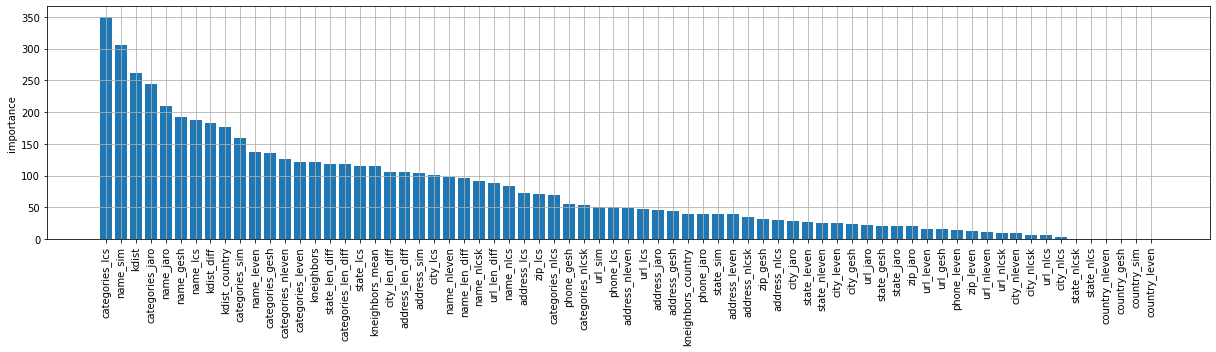

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.3 MB/s 
     |████████████████████████████████| 81 kB 8.2 MB/s 
     |████████████████████████████████| 210 kB 62.1 MB/s 
     |████████████████████████████████| 78 kB 6.5 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 112 kB 79.1 MB/s 
     |████████████████████████████████| 146 kB 63.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=225879c7afeea0a06eb6373930d1454b4a54a7c292609f1a65f404663823bf34
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [28]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-26 06:53:28,173] A new study created in memory with name: no-name-1adf3ac5-23cc-44f5-a258-e79fc27d212c
[I 2022-05-26 06:54:00,402] Trial 0 finished with value: 0.8168308850054395 and parameters: {'threshold': 0.6942833001436352}. Best is trial 0 with value: 0.8168308850054395.


CV: 0.816831


[I 2022-05-26 06:54:20,251] Trial 1 finished with value: 0.8279505543252458 and parameters: {'threshold': 0.470661728182441}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827951


[I 2022-05-26 06:54:40,937] Trial 2 finished with value: 0.826605469104383 and parameters: {'threshold': 0.5547831903694537}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.826605


[I 2022-05-26 06:54:59,933] Trial 3 finished with value: 0.7922604069194882 and parameters: {'threshold': 0.8301927350829288}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.792260


[I 2022-05-26 06:55:20,204] Trial 4 finished with value: 0.810215982323845 and parameters: {'threshold': 0.7441224912256663}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.810216


[I 2022-05-26 06:55:40,243] Trial 5 finished with value: 0.8222422160035973 and parameters: {'threshold': 0.33548247360578287}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.822242


[I 2022-05-26 06:55:59,580] Trial 6 finished with value: 0.7715157896759288 and parameters: {'threshold': 0.8885556400058926}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.771516


[I 2022-05-26 06:56:21,144] Trial 7 finished with value: 0.8028376216603633 and parameters: {'threshold': 0.20155162751155253}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.802838


[I 2022-05-26 06:56:44,470] Trial 8 finished with value: 0.8232064099496135 and parameters: {'threshold': 0.6205962634363733}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.823206


[I 2022-05-26 06:57:13,932] Trial 9 finished with value: 0.8215165528797844 and parameters: {'threshold': 0.3267809476402346}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.821517
CV: 0.501371


[I 2022-05-26 06:57:43,105] Trial 10 finished with value: 0.5013708963713092 and parameters: {'threshold': 0.009710355452234865}. Best is trial 1 with value: 0.8279505543252458.
[I 2022-05-26 06:58:06,313] Trial 11 finished with value: 0.8276858365338564 and parameters: {'threshold': 0.5099714068451392}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827686


[I 2022-05-26 06:58:26,206] Trial 12 finished with value: 0.8267423469527173 and parameters: {'threshold': 0.41604769067656355}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.826742


[I 2022-05-26 06:58:46,950] Trial 13 finished with value: 0.8277259608790674 and parameters: {'threshold': 0.5029126110646033}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827726


[I 2022-05-26 06:59:05,830] Trial 14 finished with value: 0.6743062401893936 and parameters: {'threshold': 0.9920284015096782}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.674306


[I 2022-05-26 06:59:27,088] Trial 15 finished with value: 0.79424465293667 and parameters: {'threshold': 0.17255784630165272}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.794245


[I 2022-05-26 06:59:48,090] Trial 16 finished with value: 0.826737335348066 and parameters: {'threshold': 0.41594350191688434}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.826737


[I 2022-05-26 07:00:08,597] Trial 17 finished with value: 0.8229280787074249 and parameters: {'threshold': 0.6249203213996668}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.822928


[I 2022-05-26 07:00:29,340] Trial 18 finished with value: 0.7971631230525317 and parameters: {'threshold': 0.1815340103643095}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.797163


[I 2022-05-26 07:00:50,751] Trial 19 finished with value: 0.8198592218894911 and parameters: {'threshold': 0.3071049682420684}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.819859


[I 2022-05-26 07:01:10,753] Trial 20 finished with value: 0.8278062051466936 and parameters: {'threshold': 0.45516866811863976}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827806


[I 2022-05-26 07:01:31,389] Trial 21 finished with value: 0.8278210627941842 and parameters: {'threshold': 0.45345011973102367}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827821


[I 2022-05-26 07:01:52,164] Trial 22 finished with value: 0.8260190418622002 and parameters: {'threshold': 0.39852261114842374}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.826019


[I 2022-05-26 07:02:11,714] Trial 23 finished with value: 0.8252131153937036 and parameters: {'threshold': 0.5858294079246459}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.825213


[I 2022-05-26 07:02:32,287] Trial 24 finished with value: 0.8275567076018515 and parameters: {'threshold': 0.4439109723724925}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827557


[I 2022-05-26 07:02:53,494] Trial 25 finished with value: 0.8161899854927972 and parameters: {'threshold': 0.275271093409855}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.816190


[I 2022-05-26 07:03:13,269] Trial 26 finished with value: 0.8278936659730111 and parameters: {'threshold': 0.4840958511274627}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827894


[I 2022-05-26 07:03:33,559] Trial 27 finished with value: 0.8146974528885812 and parameters: {'threshold': 0.7123580378526319}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.814697


[I 2022-05-26 07:03:56,684] Trial 28 finished with value: 0.7190681690973566 and parameters: {'threshold': 0.06010884976135156}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.719068


[I 2022-05-26 07:04:17,071] Trial 29 finished with value: 0.8217865321259348 and parameters: {'threshold': 0.6411409902732218}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.821787


[I 2022-05-26 07:04:37,836] Trial 30 finished with value: 0.8277619408231743 and parameters: {'threshold': 0.4940752174043822}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827762


[I 2022-05-26 07:04:57,823] Trial 31 finished with value: 0.8279446476823602 and parameters: {'threshold': 0.47112709822426124}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827945


[I 2022-05-26 07:05:18,564] Trial 32 finished with value: 0.8271500814584701 and parameters: {'threshold': 0.5396434017530254}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827150


[I 2022-05-26 07:05:39,481] Trial 33 finished with value: 0.8254199188468421 and parameters: {'threshold': 0.3850851447737787}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.825420


[I 2022-05-26 07:05:59,890] Trial 34 finished with value: 0.8134117571243968 and parameters: {'threshold': 0.25550860447250906}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.813412


[I 2022-05-26 07:06:20,572] Trial 35 finished with value: 0.8263740675385963 and parameters: {'threshold': 0.5610979759456314}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.826374


[I 2022-05-26 07:06:40,620] Trial 36 finished with value: 0.8243883032584671 and parameters: {'threshold': 0.3657466144902255}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.824388


[I 2022-05-26 07:07:00,957] Trial 37 finished with value: 0.802257499849872 and parameters: {'threshold': 0.7887411031816793}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.802257


[I 2022-05-26 07:07:34,424] Trial 38 finished with value: 0.8201006427912503 and parameters: {'threshold': 0.6605047924260135}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.820101


[I 2022-05-26 07:07:55,286] Trial 39 finished with value: 0.8279431841637805 and parameters: {'threshold': 0.471136101417395}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827943


[I 2022-05-26 07:08:14,724] Trial 40 finished with value: 0.8257812998438798 and parameters: {'threshold': 0.5754539261687515}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.825781


[I 2022-05-26 07:08:35,548] Trial 41 finished with value: 0.8279017208881804 and parameters: {'threshold': 0.48382995275852136}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827902


[I 2022-05-26 07:08:56,434] Trial 42 finished with value: 0.827791409841106 and parameters: {'threshold': 0.4911569404920101}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827791


[I 2022-05-26 07:09:17,662] Trial 43 finished with value: 0.8242947714036398 and parameters: {'threshold': 0.36412645373435804}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.824295


[I 2022-05-26 07:09:38,334] Trial 44 finished with value: 0.8272804520590277 and parameters: {'threshold': 0.533147758384988}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827280


[I 2022-05-26 07:09:58,292] Trial 45 finished with value: 0.8278144146635626 and parameters: {'threshold': 0.46133515452641066}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827814


[I 2022-05-26 07:10:19,321] Trial 46 finished with value: 0.814283054909285 and parameters: {'threshold': 0.7158623897618559}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.814283


[I 2022-05-26 07:10:38,877] Trial 47 finished with value: 0.8236880727257907 and parameters: {'threshold': 0.6132253260511}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.823688


[I 2022-05-26 07:11:00,254] Trial 48 finished with value: 0.822248773875975 and parameters: {'threshold': 0.3357936731265206}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.822249


[I 2022-05-26 07:11:21,204] Trial 49 finished with value: 0.827586060668656 and parameters: {'threshold': 0.514863777521898}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827586


[I 2022-05-26 07:11:41,809] Trial 50 finished with value: 0.8083539961711668 and parameters: {'threshold': 0.22630866421442758}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.808354


[I 2022-05-26 07:12:02,876] Trial 51 finished with value: 0.8275531882531418 and parameters: {'threshold': 0.4438281140665279}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827553


[I 2022-05-26 07:12:22,789] Trial 52 finished with value: 0.8279431912985715 and parameters: {'threshold': 0.47692924301772127}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827943


[I 2022-05-26 07:12:43,647] Trial 53 finished with value: 0.8279082004829681 and parameters: {'threshold': 0.48392920083486446}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827908


[I 2022-05-26 07:13:04,355] Trial 54 finished with value: 0.824828116422986 and parameters: {'threshold': 0.5928920548566657}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.824828


[I 2022-05-26 07:13:24,323] Trial 55 finished with value: 0.8260543159231036 and parameters: {'threshold': 0.400004244095434}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.826054


[I 2022-05-26 07:13:44,517] Trial 56 finished with value: 0.8187034058083743 and parameters: {'threshold': 0.6763323011191523}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.818703


[I 2022-05-26 07:14:05,248] Trial 57 finished with value: 0.8271611337541589 and parameters: {'threshold': 0.5386357700768195}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827161


[I 2022-05-26 07:14:27,277] Trial 58 finished with value: 0.8272836812155221 and parameters: {'threshold': 0.43333308828654404}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.827284


[I 2022-05-26 07:14:48,674] Trial 59 finished with value: 0.8191100092681438 and parameters: {'threshold': 0.29973251314473653}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.819110


[I 2022-05-26 07:15:09,512] Trial 60 finished with value: 0.8230042694490015 and parameters: {'threshold': 0.3440749073425389}. Best is trial 1 with value: 0.8279505543252458.


CV: 0.823004


[I 2022-05-26 07:15:30,337] Trial 61 finished with value: 0.8279693955701533 and parameters: {'threshold': 0.4753231361327991}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827969


[I 2022-05-26 07:15:51,054] Trial 62 finished with value: 0.8279214110738963 and parameters: {'threshold': 0.48345432316312276}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827921


[I 2022-05-26 07:16:12,241] Trial 63 finished with value: 0.8267299219819594 and parameters: {'threshold': 0.4144382496854454}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826730


[I 2022-05-26 07:16:32,066] Trial 64 finished with value: 0.8275763238180807 and parameters: {'threshold': 0.5162450595368703}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827576


[I 2022-05-26 07:16:53,164] Trial 65 finished with value: 0.8278151913183166 and parameters: {'threshold': 0.4587482340528411}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827815


[I 2022-05-26 07:17:12,952] Trial 66 finished with value: 0.8266241400150692 and parameters: {'threshold': 0.5541811711631072}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826624


[I 2022-05-26 07:17:34,234] Trial 67 finished with value: 0.8251251774309051 and parameters: {'threshold': 0.37836979631485157}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.825125


[I 2022-05-26 07:18:02,606] Trial 68 finished with value: 0.7611495812748106 and parameters: {'threshold': 0.909126597633928}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.761150


[I 2022-05-26 07:18:26,349] Trial 69 finished with value: 0.8279417985605633 and parameters: {'threshold': 0.4724390443501506}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827942


[I 2022-05-26 07:18:46,433] Trial 70 finished with value: 0.8270066202070459 and parameters: {'threshold': 0.4239577973348707}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827007


[I 2022-05-26 07:19:07,272] Trial 71 finished with value: 0.8279349614376991 and parameters: {'threshold': 0.4825726924176236}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827935


[I 2022-05-26 07:19:27,937] Trial 72 finished with value: 0.8279538482088762 and parameters: {'threshold': 0.46807314920889187}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827954


[I 2022-05-26 07:19:48,319] Trial 73 finished with value: 0.8241340099656802 and parameters: {'threshold': 0.6049765232191512}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.824134


[I 2022-05-26 07:20:08,360] Trial 74 finished with value: 0.8278057230926406 and parameters: {'threshold': 0.4589337907582765}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827806


[I 2022-05-26 07:20:29,009] Trial 75 finished with value: 0.8261901314283842 and parameters: {'threshold': 0.5662068440187149}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826190


[I 2022-05-26 07:20:49,848] Trial 76 finished with value: 0.8275961557927699 and parameters: {'threshold': 0.5200587675327486}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827596


[I 2022-05-26 07:21:11,027] Trial 77 finished with value: 0.826086377058736 and parameters: {'threshold': 0.4012671010100497}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826086


[I 2022-05-26 07:21:31,913] Trial 78 finished with value: 0.82710509703832 and parameters: {'threshold': 0.4263252299011388}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827105


[I 2022-05-26 07:21:51,317] Trial 79 finished with value: 0.8222818416582623 and parameters: {'threshold': 0.634757040419959}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.822282


[I 2022-05-26 07:22:12,364] Trial 80 finished with value: 0.8240214742374891 and parameters: {'threshold': 0.3587420649904333}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.824021


[I 2022-05-26 07:22:32,260] Trial 81 finished with value: 0.8279235922838662 and parameters: {'threshold': 0.47792116865744383}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827924


[I 2022-05-26 07:22:53,007] Trial 82 finished with value: 0.8279671201294567 and parameters: {'threshold': 0.46949811658087526}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827967


[I 2022-05-26 07:23:13,760] Trial 83 finished with value: 0.8277185498783338 and parameters: {'threshold': 0.50612068935794}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827719


[I 2022-05-26 07:23:34,359] Trial 84 finished with value: 0.8269888552336101 and parameters: {'threshold': 0.5446721071647712}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826989


[I 2022-05-26 07:23:55,208] Trial 85 finished with value: 0.827921575009443 and parameters: {'threshold': 0.46638719683929386}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827922


[I 2022-05-26 07:24:15,149] Trial 86 finished with value: 0.827542910393821 and parameters: {'threshold': 0.44276470121879846}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827543


[I 2022-05-26 07:24:36,173] Trial 87 finished with value: 0.825433620744034 and parameters: {'threshold': 0.38527437508980833}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.825434


[I 2022-05-26 07:24:56,079] Trial 88 finished with value: 0.825669272416485 and parameters: {'threshold': 0.5785346582021434}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.825669


[I 2022-05-26 07:25:17,429] Trial 89 finished with value: 0.8203512795824032 and parameters: {'threshold': 0.3123725309125125}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.820351


[I 2022-05-26 07:25:38,190] Trial 90 finished with value: 0.8274543072707613 and parameters: {'threshold': 0.5256667231779247}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827454


[I 2022-05-26 07:25:58,947] Trial 91 finished with value: 0.8279512768986249 and parameters: {'threshold': 0.4815650488627695}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827951


[I 2022-05-26 07:26:19,940] Trial 92 finished with value: 0.8277119960094247 and parameters: {'threshold': 0.5082135244241346}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827712


[I 2022-05-26 07:26:40,794] Trial 93 finished with value: 0.8267042501247651 and parameters: {'threshold': 0.4141317258166896}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826704


[I 2022-05-26 07:27:01,685] Trial 94 finished with value: 0.8277849436735631 and parameters: {'threshold': 0.4954832671818769}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827785


[I 2022-05-26 07:27:21,811] Trial 95 finished with value: 0.8275738600974618 and parameters: {'threshold': 0.44441020421579963}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827574


[I 2022-05-26 07:27:42,667] Trial 96 finished with value: 0.827939850693089 and parameters: {'threshold': 0.4743255555430688}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827940


[I 2022-05-26 07:28:03,921] Trial 97 finished with value: 0.827153405673212 and parameters: {'threshold': 0.5397051007787474}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827153


[I 2022-05-26 07:28:28,764] Trial 98 finished with value: 0.8279321365063272 and parameters: {'threshold': 0.4674324780390309}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.827932


[I 2022-05-26 07:28:55,720] Trial 99 finished with value: 0.8260216967759532 and parameters: {'threshold': 0.39880127118606223}. Best is trial 61 with value: 0.8279693955701533.


CV: 0.826022


In [29]:
threshold = study.best_params['threshold']
threshold

0.4753231361327991

In [30]:
study.best_value

0.8279693955701533

In [31]:
test_pred_df = test_data[test_data['pred'] > threshold][['id', 'match_id']]
out_df = pd.DataFrame()
out_df['id'] = test_data['id'].unique().tolist()
out_df['match_id'] = out_df['id']
out_df = pd.concat([out_df, test_pred_df])
out_df = out_df.groupby('id')['match_id'].\
                    apply(list).reset_index()
out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
out_df = post_process(out_df)

score = get_score(out_df)
print(f"CV: {score:.6f}")

CV: 0.827969


# 間違っているものの中身を見る

In [32]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [33]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,141949.000000,141949.000000,137644.000000,137644.000000,132336.000000,146263.000000,146263.0,146263.000000,146263.000000,146263.000000,...,146263.000000,146259.000000,146259.000000,146259.000000,146259.000000,146263.000000,146259.000000,146259.000000,146259.000000,146263.000000
mean,0.006423,6.319981,0.003485,6.365770,0.421122,6.620082,1.0,0.261151,0.409368,16.460458,...,0.998639,0.998766,0.002543,0.998749,1.997532,0.000027,0.001272,0.998766,0.998766,0.181969
std,0.048053,5.196823,0.023663,5.227307,2.322847,5.268178,0.0,0.292422,0.249079,9.451968,...,0.036861,0.034395,0.070409,0.034961,0.068790,0.005229,0.035204,0.034395,0.034395,0.144292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012
25%,0.000445,2.000000,0.000331,2.000000,0.005857,2.000000,1.0,0.000000,0.208333,10.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.049677
50%,0.001104,5.000000,0.000844,5.000000,0.056462,5.000000,1.0,0.175547,0.391304,15.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.152784
75%,0.003030,10.000000,0.002322,10.000000,0.320501,10.000000,1.0,0.485270,0.588235,22.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.300669
max,4.310371,19.000000,2.388985,19.000000,170.784270,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.475302


In [34]:
false_negative.sample(min(false_negative.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
3940066,E_eb480fd1225c4f,E_a19e5549970049,0.000321,6.0,P_75f050a0c8830b,0.000280,6.0,0.145809,6.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.094282
8109932,E_3e032e4440a2c6,E_515ffc76cd9485,0.003071,14.0,P_fbc73b525358ef,0.002896,17.0,0.060591,15.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.066308
1302307,E_496eb117db9b19,E_251e27f1563d05,0.008468,2.0,P_36bd00066046f8,0.008231,2.0,0.028749,2.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.349733
10176375,E_df0d9a57f22fad,E_a99cf8669e9d0f,0.004288,17.0,P_d39b1777ac58b7,0.004205,17.0,0.019816,17.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.004122
611093,E_12aca2260828cd,E_0df3d6f62a6d0a,0.000084,1.0,P_2f818d7f9a8c67,0.000064,1.0,0.311430,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.391310
589511,E_09021349fda32e,E_471248e0751dda,0.000562,1.0,P_1a3fe45a60c1d2,0.000561,1.0,0.002458,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.010835
2934841,E_275ca95d7b8b88,E_b719e45602e265,0.003911,5.0,P_bfee587b3eb2dd,0.003270,4.0,0.196169,4.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.407769
2604804,E_92ddd2e28fd1a4,E_ce72455823acc6,0.000320,4.0,P_134489478eeca2,0.000315,4.0,0.015641,4.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.197077
980753,E_b89faf08bd5502,E_6d0f064a4b92ae,0.000613,1.0,P_d8abef1712d964,0.000607,1.0,0.009504,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.280816
7641782,E_6b87ffcac5e752,E_7f6f0e7c0c3578,0.004278,13.0,P_8c5c7dd7c0428d,0.004272,14.0,0.001537,13.5,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.153201


In [35]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
814831,E_b6fdea8504e006,Drive thru kfc ringroad,3.568042,98.625202,Jl.ringroad,Medan,Indonesia,NaN,ID,NaN,NaN,Fast Food Restaurants,P_d0c99954236590,4,1.0
840415,E_bcbaa250c31f5f,KFC,3.569241,98.626572,Jln.Gagak Hitam,Medan,North Sumatra,NaN,ID,NaN,NaN,NaN,P_d0c99954236590,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
505901,E_71bf89620a9e62,Saat Kulesi,38.418884,27.128717,Konak Meydanı,İzmir,NaN,NaN,TR,NaN,NaN,Historic Sites,P_c8805f7729b1d1,4,1.0
757780,E_aa3bb7656032c5,İzmir Clock Tower,38.418402,27.129132,Konak/Izmir,İzmir,NaN,NaN,TR,NaN,NaN,NaN,P_c8805f7729b1d1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
480340,E_6bf2d81c6b469f,BhBahcesehir IMKB Anadolu Endustri Teknik ve M...,41.074452,28.663682,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_df2cd68573fa97,2,1.0
483292,E_6c9d841c851382,Bahçeşehir İMKB Mesleki Ve Teknik Anadolu Lisesi,41.080692,28.662477,Bahçeşehir / Boğazköy,İstanbul,NaN,NaN,TR,NaN,NaN,General Colleges & Universities,P_df2cd68573fa97,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
104771,E_177c6e2ec6c8be,PENNY-Markt Discounter,51.459050,6.982005,Haedenkampstr. 6D,Essen,NaN,45143,DE,http://www.penny.de,+4922120199959,Supermarkets,P_93a899e788ec2e,3,1.0
986820,E_ddb176a82afa84,PENNY-Markt Discounter,51.461056,6.971474,Kopernikusstr. 2-6,Essen,NaN,45143,DE,http://www.penny.de,+4922120199959,Supermarkets,P_93a899e788ec2e,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
393263,E_585a8686f33a6d,Finans Bank E-5 Subesi,40.764046,29.942458,NaN,NaN,NaN,NaN,TR,NaN,NaN,Banks,P_a39098d4816f25,2,1.0
648859,E_91d30e2bebf87b,Finansbank Kocaeli Şube,40.763720,29.943215,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_a39098d4816f25,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
207848,E_2ea4a5b9a0a20e,Mc D Jl djuanda,-6.601002,106.794906,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8b2031a969e4e1,4,1.0
529454,E_76fb676320656c,Mc Donald's Juanda,-6.602704,106.798720,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_8b2031a969e4e1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
567200,E_7f7aab66bbda89,POM BENSIN DPN TARBAK,-6.905983,107.618880,Jl. RE martadinata,Bandung,NaN,NaN,ID,NaN,NaN,Gas Stations,P_32b4d027767154,3,1.0
977600,E_db9e4ac5fbab7b,SPBU Riau,-6.906083,107.618731,Jl.Riau,Bandung,Jawa Barat,NaN,ID,NaN,NaN,NaN,P_32b4d027767154,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
101356,E_16b6535f9fe560,AEON MALL BSD CITY SERPONG,-6.304391,106.647736,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0
941485,E_d377a5aecda3f9,Aeon Mall,-6.300248,106.649051,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_9ca6f5784b5b37,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
825911,E_b9769bcd97cdb1,7-Eleven,27.908565,-82.721503,6270 150th Ave N,Clearwater,FL,33760,US,https://www.7-eleven.com/locations/fl/clearwat...,7275367156,Convenience Stores,P_7a00bed2548f63,1,1.0
1111516,E_f9da4962609f2f,7 11,27.908358,-82.719047,NaN,South Highpoint,FL,NaN,US,NaN,NaN,Convenience Stores,P_7a00bed2548f63,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
213172,E_2fdc6f1aeee988,Московский зоопарк,55.761807,37.578023,"Большая Грузинская ул., 1",Москва,Москва,123242,RU,http://www.moscowzoo.ru,+74992522951,Zoos,P_362b42ac17f411,4,1.0
878855,E_c567c01ff0f6df,Дирекция Зоопарка,55.762440,37.580316,NaN,NaN,NaN,NaN,RU,NaN,NaN,Offices,P_362b42ac17f411,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
368712,E_52d331ced3aa58,У Михаила Еленовича,60.024163,30.424755,NaN,NaN,NaN,NaN,RU,NaN,NaN,Auditoriums,P_c2f0b0b6e9077a,4,1.0
863089,E_c1dbcd35dd1596,У Идиота На Уроке😏,60.024539,30.424606,NaN,NaN,NaN,NaN,RU,NaN,NaN,High Schools,P_c2f0b0b6e9077a,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
364520,E_51e9eba66666dc,Hot&Roll,3.198320,101.742164,Wangsa Walk Mall,Wangsa Maju,Kuala Lumpur,53300,MY,NaN,NaN,Snack Places,P_3b9aeda6edd445,1,1.0
1018563,E_e4d741ba452b80,Hot And Roll,3.198724,101.742361,NaN,NaN,NaN,NaN,MY,NaN,NaN,Burrito Places,P_3b9aeda6edd445,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
528902,E_76db084e2f1c67,Адский кабинет,55.725151,37.565991,NaN,NaN,NaN,NaN,RU,NaN,NaN,College Auditoriums,P_25f96e813a6a28,4,1.0
915733,E_cdb4b20b2d4599,Кабинет 335,55.725974,37.566400,NaN,NaN,NaN,NaN,RU,NaN,NaN,Comedy Clubs,P_25f96e813a6a28,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
220289,E_31772fd7cb2e29,Sukru saracoglu,40.990742,29.037904,NaN,NaN,NaN,NaN,TR,NaN,NaN,Playgrounds,P_17b5060b096be9,4,1.0
445678,E_642aee633c3541,FENERBAHÇE ŞÜKRÜ SARAÇOĞLU STADYUMU,40.990068,29.040927,Kızıltoprak,İstanbul,Kadıköy,34500,TR,NaN,NaN,Soccer Fields,P_17b5060b096be9,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
230689,E_33c8b02c563e6e,Tape Dispatch & Video Library Lt. 3A Trans TV,-6.241251,106.829813,Gd. Trans TV Jl. Kapt. Piere Tendean Kav 12-14A,Jakarta,NaN,12790,ID,NaN,NaN,NaN,P_745299120115a1,4,1.0
923550,E_cf75bc2374d242,Tangga Darurat Lantai 5,-6.241145,106.829839,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_745299120115a1,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
728840,E_a3b870a42f9b70,vodafone Bayisi Kalkan Şubesi,36.266135,29.413595,Kalamar Yolu,NaN,NaN,NaN,TR,NaN,NaN,Distribution Centers,P_dfa782570a9af1,1,1.0
825912,E_b9769f6ce64654,VODAFONE EKİNCİ ILETİSİM,36.266454,29.413480,Kalkan,Antalya,KAŞ,07960,TR,http://www.vodafone.com.tr,02428441336,Mobile Phone Shops,P_dfa782570a9af1,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
579142,E_822eeb37a531a6,Кабинет 46,44.962955,34.114773,NaN,NaN,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0
1078004,E_f240f7b075cb66,10-Б(ботаны),44.964033,34.114869,NaN,NaN,NaN,NaN,UA,NaN,NaN,NaN,P_65769c7e8a4d68,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
101052,E_16a5dcca2177de,Caka Park,38.610840,27.410074,NaN,NaN,NaN,NaN,TR,NaN,NaN,Restaurants,P_f89ccde8336e21,2,1.0
351173,E_4ee9ea91a9cfb5,CAKA Park Akmescit,38.609055,27.408898,Akmescit Mahallesi 4101 Sokak,Manisa,NaN,NaN,TR,NaN,+902362315151,Cafés,P_f89ccde8336e21,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
570415,E_803878b8d6d540,New Club 99,41.035415,28.978781,Balo Sokak No: 31/1,Istanbul,Türkiye,34340,TR,NaN,NaN,"Nightclubs, General Entertainment",P_9176f3f37fb30f,2,1.0
1001237,E_e0e91844350b1a,TheHall,41.035576,28.979435,Kucuk Bayram sok. No: 7 Beyoglu,Istanbul,NaN,NaN,TR,NaN,NaN,NaN,P_9176f3f37fb30f,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1221,E_0049d1da7d3819,Orange Inn Hotel,1.469775,103.736987,Tmn Nong Chik,NaN,NaN,NaN,MY,NaN,NaN,Hotels,P_5053298dc7b271,1,1.0
1113368,E_fa4a11885babbb,Neverland Hotel,1.466804,103.747120,NaN,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_5053298dc7b271,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
291644,E_417ee007860a65,Tap Room,19.415681,-99.163506,NaN,NaN,NaN,NaN,MX,NaN,NaN,Irish Pubs,P_b187e37501eb50,2,1.0
552004,E_7c11bea613295d,Microcerveceria,19.415764,-99.163478,NaN,NaN,NaN,NaN,MX,NaN,NaN,Cajun / Creole Restaurants,P_b187e37501eb50,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
620478,E_8b826c8047f2cb,Özel Versa Hastanesi,38.630927,34.738131,"Güzelyurt, Ürgüp Cd. No:43, Nevşehir Merkez",Nevşehir,Nevşehir,50300,TR,NaN,+903842143232,NaN,P_91bb38b2ec5806,4,1.0
718082,E_a14ce746634d89,Versa Hastanesi Kan Alma,38.631049,34.737969,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_91bb38b2ec5806,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
257655,E_39d9d71bee07ec,lunapark kavşak,37.761294,29.105013,NaN,NaN,NaN,NaN,TR,NaN,NaN,General Travel,P_161b205e1ade94,3,1.0
415592,E_5d5dc1b0bdc46e,Lunapark,37.760586,29.112122,Cumhuriyet Mahallesi,Denizli,NaN,NaN,TR,NaN,NaN,General Entertainment,P_161b205e1ade94,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
800986,E_b3e081091adcd1,Букингем Палас Манушки🇬🇧,55.685081,37.573961,NaN,NaN,NaN,NaN,RU,NaN,NaN,English Restaurants,P_d07b22b3d198cd,4,1.0
855498,E_c024473231ff1a,медкабинет 1534🌚,55.684385,37.568663,NaN,NaN,NaN,NaN,RU,NaN,NaN,Medical Centers,P_d07b22b3d198cd,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
694617,E_9c05e7ff8f195a,На Байкале,53.072576,106.807082,NaN,NaN,NaN,NaN,RU,NaN,NaN,NaN,P_a0ae518f194f66,4,1.0
996539,E_dfde5aa0913fe7,Берег Байкала,51.851933,106.070688,NaN,NaN,NaN,NaN,RU,NaN,NaN,Lakes,P_a0ae518f194f66,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
60663,E_0d93c0cfeb0119,Lotus#บางปะกอก,13.677462,100.501010,NaN,NaN,NaN,NaN,TH,NaN,NaN,Convenience Stores,P_4e65513be455b5,4,1.0
547198,E_7afaf3217b0889,Lotus # บางประกอก,13.677989,100.501579,NaN,NaN,NaN,NaN,TH,NaN,NaN,Convenience Stores,P_4e65513be455b5,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
175748,E_27690853348bf5,Starbucks - City stars,30.071717,31.348397,مدينة نصر,NaN,NaN,NaN,EG,NaN,NaN,Cafés,P_32f1c9489f2183,3,1.0
917727,E_ce24cbcdd3f118,Starbucks,30.073476,31.345410,CityStars,Heliopolis,Muḩāfaz̧at al Qāhirah,NaN,EG,http://mena.starbucks.com,+20224153277,"Coffee Shops, Cafés",P_32f1c9489f2183,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
469520,E_69848e5878dfac,Armatör Yakup Aksoy Denizcilik Meslek Lisesi A...,40.414207,26.670025,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_69cc9f20b48a63,3,1.0
835186,E_bb8d523208d344,Armatör Yakup Aksoy Lisesi Makina Atölyesi,40.412957,26.669714,NaN,NaN,NaN,NaN,TR,NaN,NaN,High Schools,P_69cc9f20b48a63,3,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
103972,E_174d42125f7a27,Kyk Yurdu Balo Salonu,36.317339,33.874275,NaN,NaN,NaN,NaN,TR,NaN,NaN,NaN,P_32f50909896901,4,1.0
854045,E_bfce4eccc82f71,Taşucu Kız Öğrenci Yurdu Sahili,36.317982,33.882824,NaN,NaN,NaN,NaN,TR,NaN,NaN,Beaches,P_32f50909896901,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
509907,E_72a2bf2c289427,jcp optical pop-up shop,42.687751,-73.847158,Cross Gates Mall,Albany,NY,12203,US,NaN,NaN,Optical Shops,P_719e676c274b6f,3,1.0
546121,E_7aba0be6badb1a,JCPenney,42.688153,-73.847561,120 Washington Avenue Ext Ste 40,Albany,NY,12203,US,https://stores.jcpenney.com/ny/albany/clothing...,5184560824,"Department Stores, Clothing Stores, Boutiques",P_719e676c274b6f,3,1.0


labelが0なのに1と予測しているもの

In [36]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,56788.000000,56788.000000,54534.000000,54534.000000,53170.000000,57579.00000,57579.0,57579.000000,57579.000000,57579.000000,...,57579.00000,57577.000000,57577.000000,57577.000000,57577.000000,57579.0,57577.000000,57577.000000,57577.000000,57579.000000
mean,0.009234,4.301155,0.002655,4.152950,0.411783,4.51148,0.0,0.530709,0.613363,12.144098,...,0.99875,0.998810,0.002484,0.998761,1.997621,0.0,0.001242,0.998810,0.998810,0.680820
std,0.137109,4.828646,0.010388,4.652136,1.803402,4.92758,0.0,0.342490,0.255705,9.442927,...,0.03534,0.034028,0.070312,0.035122,0.068056,0.0,0.035156,0.034028,0.034028,0.142261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.475324
25%,0.000278,1.000000,0.000212,1.000000,0.007649,1.00000,0.0,0.259318,0.444444,5.000000,...,1.00000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.555916
50%,0.000809,2.000000,0.000597,2.000000,0.065440,2.00000,0.0,0.583836,0.631579,11.000000,...,1.00000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.660569
75%,0.002778,6.000000,0.001964,5.000000,0.309278,6.00000,0.0,0.809033,0.810811,17.000000,...,1.00000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.791263
max,17.169573,19.000000,0.833281,19.000000,99.538619,19.00000,0.0,1.000000,1.000000,57.000000,...,1.00000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999889


In [37]:
false_positive.sample(min(false_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
5980914,E_80d9f326f2357b,E_c843de2beeda36,0.008348,10.0,P_8defb57ec8cfff,0.008337,15.0,0.001302,12.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.778276
796345,E_65dcf037580c61,E_3ae255db89dbf2,0.000189,1.0,P_d5abdd4c4f42fc,0.000183,1.0,0.037155,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.942652
2266143,E_fad1fc8dd818d7,E_663229b433252f,0.000883,3.0,P_9b643634269881,0.000857,3.0,0.029918,3.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.641926
2663815,E_ad5550ef3030b3,E_66e83cce43f054,0.000321,4.0,P_e4acdb99198334,0.000262,3.0,0.224623,3.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.541995
3852506,E_c3d37dd136d001,E_c5ac108d4abd10,0.000826,6.0,P_fc0eedd62744a7,0.000793,7.0,0.041577,6.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.526656
678982,E_312556181315b9,E_d420e426103822,0.000631,1.0,P_e8da820836592c,0.000631,1.0,0.000924,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.881278
1385639,E_6ed759852e3661,E_b3763a6f805e69,0.004653,2.0,P_0ce0d7d893c491,0.004610,2.0,0.009335,2.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.605667
575083,E_029414f597703d,E_8eaf2174392500,0.000454,1.0,P_0b844814448c52,0.000263,1.0,0.723859,1.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.972370
6045790,E_9dd6b372ad1774,E_45b27c3dce8969,0.001884,10.0,P_d4508a1ad5d25d,0.001883,10.0,0.000278,10.0,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.825776
4560234,E_02438bcb8a4a84,E_f02cea206d4af8,0.000649,8.0,P_853455bef22604,0.000648,9.0,0.001717,8.5,0,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.634708


In [38]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1015635,E_e42b550a68638f,esin sitesi 2-B blok,41.000500,29.074663,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_1c2bd22906f6d9,0,1.0
1039836,E_e99eeb24b8c7ef,esin sitesi 2-E blok,41.000561,29.074567,NaN,NaN,NaN,NaN,TR,NaN,NaN,Housing Developments,P_b80bd6346f8d7f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
767580,E_ac6af8e6564c20,TUT Pretoria Campus Building 21,-25.731556,28.161538,NaN,NaN,NaN,NaN,ZA,NaN,NaN,College Administrative Buildings,P_272f59908103cb,0,1.0
822707,E_b8bef6e8e6543c,TUT Pretoria Campus Building 2,-25.732748,28.164166,Staatsartillerie Road,Pretoria,NaN,NaN,ZA,NaN,NaN,"College Engineering Buildings, Universities",P_a394e036ca19f0,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
192841,E_2b4533dfd48dd3,弘法山古墳橋,36.215459,137.982493,神田 / 並柳,松本市,長野県,NaN,JP,NaN,NaN,Bridges,P_0842ad5166753e,0,1.0
947743,E_d4e1cdcdac5406,弘法山古墳,36.211839,137.983926,並柳2,松本市,長野県,NaN,JP,NaN,NaN,Historic Sites,P_21eac9f2e2b412,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
10496,E_0263adad79439b,Dunkin' Donuts - SASCO,24.662217,46.708528,NaN,Riyadh,Riyadh,12613,SA,NaN,NaN,Donut Shops,P_31b90aedfb2f80,0,1.0
1058914,E_edf8713e73998f,Dunkin’ Donuts,24.659549,46.710492,SABB Head Office,Riyadh,Riyadh,12628,SA,NaN,NaN,"Donut Shops, Coffee Shops",P_9ba89c8954a8db,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
628973,E_8d6d70c722fdee,Gedung D4 lantai 3 FE UM,-7.962912,112.614211,jalan semarang no 5,malang,NaN,NaN,ID,NaN,NaN,EV Charging Stations,P_382af3e38d4671,0,1.0
895467,E_c9221e480e2f2f,Gedung D4 FE UM,-7.961581,112.615590,Jl. Semarang No. 5 Malang,Malang,East Java,NaN,ID,NaN,NaN,College Academic Buildings,P_4dca499d84f748,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
591752,E_8503d18d4cc3f4,Ruang 10120 UNPAR,-6.877540,107.609353,NaN,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_2f109789f0e040,0,1.0
765600,E_abf9061916bf90,Ruang 10122 gd 10 UNPAR,-6.877633,107.609422,NaN,Bandung,West Java,NaN,ID,NaN,NaN,NaN,P_04cef2c03ce0b5,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
821444,E_b877b3df30e136,Sint-Sixtuswandelroute,50.890167,2.725264,NaN,NaN,NaN,NaN,BE,NaN,NaN,Trails,P_25234fb932913a,0,1.0
889530,E_c7d141ea6925ae,Sint-Sixtusdreef,50.895485,2.722176,Sint-Sixtusdreef,Westvleteren,West-Vlaanderen,NaN,BE,NaN,NaN,Trails,P_494db529194f75,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
321416,E_4842572be2ee6c,Gedung FPIPS lt.VI R.38,-6.860980,107.59291,Universitas Pendidikan Indonesia,Bandung,West Java,NaN,ID,NaN,NaN,College Academic Buildings,P_105aa1300e0cdd,0,1.0
599802,E_86cf42b00aa40c,Gedung FPIPS lt. VI r.37,-6.860947,107.59285,NaN,Bandung,NaN,NaN,ID,NaN,NaN,NaN,P_024f6340367aed,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
653306,E_92cf29b2db20a0,Gedung H 2.4,-0.912948,100.459824,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_083ad55247b24f,4,1.0
679772,E_98b50dd429801b,Gedung A Universitas Andalas,-0.913808,100.459620,Jl. Universitas Andalas,Padang,West Sumatra,25163,ID,NaN,NaN,"College Classrooms, College Science Buildings",P_e12c4382565ac7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
676794,E_98067bb8c5049a,XFINITY Store by Comcast,36.740982,-119.780556,3020 Tulare St,Fresno,CA,93721,US,NaN,(559) 481-6752,Business Services,P_4b0f1bf76ba0a6,0,1.0
985683,E_dd6fb69637275a,XFINITY Store by Comcast,36.747447,-119.773582,3041 E Grant Ave,Fresno,CA,93701,US,NaN,(559) 328-5494,Business Services,P_0886799e8a3a82,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
156013,E_22f299c1d49b76,Malatya,38.424732,38.366188,NaN,NaN,NaN,NaN,TR,NaN,NaN,Amphitheaters,P_82f591af613b32,1,1.0
860143,E_c131668b4cf39f,Malatya Nargile ALİ DAYI,38.347465,38.366759,NaN,NaN,NaN,NaN,TR,NaN,NaN,Other Great Outdoors,P_39d449914647d4,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
195379,E_2bd66bc8a88b77,Keuken,51.225070,3.228255,Dudzeelse Steenweg,Brugge,NaN,NaN,BE,NaN,NaN,Breakfast Spots,P_5a5a67ab38598d,0,1.0
1077863,E_f239e75ba2d210,keukentafel,51.224827,3.228160,Dudzeelse Steenweg,Brugge,NaN,NaN,BE,NaN,NaN,Diners,P_d348ad64d3581a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
238427,E_35837b6d93e0b9,ก๋วยเตี๋ยว CP,13.840310,100.546619,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_d64efa422762fc,0,1.0
303157,E_4412dde6bcf576,CP Fresh Mart (ซีพี เฟรชมาร์ท),13.840387,100.546599,88/166 Tessaban Songkhro Rd,Chatuchak,Bangkok,10900,TH,http://www.cpfreshmartshop.com,839890054,Grocery Stores,P_53c51683d1a36f,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
264299,E_3b5a69d5f6a9db,Kerang rebus ojo lali & nasi goreng cumi2,3.590298,98.649405,Jln. Gatot subroto,Medan,Indonesia,NaN,ID,NaN,NaN,"Diners, Indonesian Restaurants",P_7eec9fa76a109e,0,1.0
892119,E_c867cd68840320,Kerang rebus,3.590330,98.653338,Jl. Gatot subroto simp. Ayahanda,Medan,North Sumatra,NaN,ID,NaN,NaN,NaN,P_21a90f887024ff,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
918435,E_ce4d1498354e43,Grand Mal Bekasi,-6.228051,106.983332,Jalan Jenderal Sudirman No. 1,Bekasi,Jawa Barat,NaN,ID,http://lippomalls.com/site/grand-mal-bekasi/pa...,218855328,Shopping Malls,P_b2b044421189ef,4,1.0
1082711,E_f34c493062f441,GTI Tiberias Grand Mall Bekasi,-6.228854,106.982357,NaN,NaN,NaN,NaN,ID,NaN,NaN,Churches,P_9b78643011b83d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
72919,E_1051a4f99c882c,HELP UC - KPD Block A - SR 3.1,3.151640,101.665470,NaN,NaN,NaN,NaN,MY,NaN,NaN,NaN,P_4b3b2d80e88aa9,0,1.0
987734,E_dde7980db0ec08,HELP UC - KPD Block E,3.150896,101.664477,"Jalan Dungun, Bukit Damansara",Kuala Lumpur,WP Kuala Lumpur,50490,MY,NaN,NaN,"College Academic Buildings, Offices, College Labs",P_c4a2ec78d63ad2,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
344861,E_4d7c9503dd9f89,Hcc Site1,5.405753,100.305255,NaN,NaN,NaN,NaN,MY,NaN,NaN,Strip Clubs,P_a19a8872b656c7,0,1.0
362641,E_517dd02bca9dea,Hcc Site16,5.405718,100.305216,NaN,NaN,NaN,NaN,MY,NaN,NaN,Student Centers,P_f50ba70682ba45,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
903037,E_cad7dcdcdbf3d4,BWI Baggage Claim 2,39.179842,-76.671047,NaN,Baltimore,MD,21240,US,NaN,NaN,Baggage Claims,P_6020e38f3b7b49,0,1.0
1058434,E_eddbafb7bd3cc5,BWI Baggage Claim 3,39.179551,-76.671227,BWI Airport,Baltimore,MD,21240,US,NaN,NaN,Baggage Claims,P_c965f298a5ec5d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
419798,E_5e4e2c48ac3bed,Farm 7,40.597001,-73.973736,NaN,Brooklyn,NY,11223,US,NaN,NaN,Farms,P_e651728587cc36,0,1.0
1012143,E_e36148ecd19d52,Farm 1,40.596984,-73.973743,NaN,Brooklyn,NY,11223,US,NaN,NaN,Farms,P_9caf726143e3b8,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
265437,E_3b9ca729005d3e,Salon seudun ammattiopisto Tietoliikenne,60.393291,23.117588,NaN,NaN,NaN,NaN,FI,NaN,NaN,Trade Schools,P_9f9472fa2d4949,0,1.0
414841,E_5d34c64c2b69ca,Luokka B23,60.392706,23.116981,NaN,NaN,NaN,NaN,FI,NaN,NaN,Trade Schools,P_3c3a758b1ef100,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
64615,E_0e75b71fe7a51a,EBC,19.428694,-99.161040,NaN,NaN,NaN,NaN,MX,NaN,NaN,NaN,P_3a2bac63e85ff2,1,1.0
439057,E_62acce3e662f9f,EBC Edificio G Salon 422,19.429337,-99.160556,NaN,NaN,NaN,NaN,MX,NaN,NaN,College Classrooms,P_f977b47f14f0a6,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
379853,E_5557e74239ce77,klinik Dent.co (dentist's) drg. Denta kusuma,-6.887616,107.623726,Terusan Tubagus Ismail no.1,Bandung,Indonesia,NaN,ID,NaN,NaN,Dentist's Offices,P_d4c458c55c08e8,0,1.0
784405,E_b0320c79458573,Dent.co dental clinic,-6.887683,107.623737,Jl. Terusan Tubagus Ismail No.1A.,Bandung,West Java,NaN,ID,NaN,222535666,Dentist's Offices,P_7b8292a5ce120f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
72736,E_1046f5c60a5021,Marriott Information Technology,39.114458,-77.194735,9737 Washingtonian Blvd,Gaithersburg,MD,20878,US,NaN,NaN,Offices,P_e397a01a449efa,1,1.0
378993,E_552578dbb100b6,Washingtonian II,39.114369,-77.194859,9737 Washingtonian Blvd,Gaithersburg,MD,20878,US,NaN,NaN,Offices,P_d873d8be017a3e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
621243,E_8bad65fbe59b24,VBL Bahnhof - Kante D,47.050713,8.309679,NaN,NaN,NaN,NaN,CH,NaN,NaN,Bus Stops,P_dbc6818880d507,0,1.0
1006518,E_e216e0fb7098ba,Vbl Bahnhof - Kante K,47.050629,8.310979,NaN,NaN,NaN,NaN,CH,NaN,NaN,Bus Stations,P_954631819c2f35,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
184021,E_294ad40bbe7825,大曽根駅北口,35.191736,136.937329,NaN,名古屋市,愛知県,461-0048,JP,NaN,NaN,Train Stations,P_d9587f4aaa927d,1,1.0
666423,E_95b7a2634b163d,名鉄瀬戸線 大曽根駅 (Ozone Sta.)(ST06),35.191570,136.936897,東区矢田南5-2-6,Nagoya-shi,愛知県,461-0048,JP,https://top.meitetsu.co.jp,529811375,Train Stations,P_e09369108b55e7,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
294873,E_423832bdec8093,Museum of Science & Industry (MOSI),28.053519,-82.404930,4801 E Fowler Ave,Tampa,FL,33617,US,http://www.mosi.org,8139876000,Science Museums,P_92d348a00bd8de,2,1.0
1015973,E_e43e2ce15b6d5c,MOSI - Schiff Board Room,28.053216,-82.405078,4801 E Fowler Ave,Tampa,FL,33617,US,NaN,8139876000,"Science Museums, Coworking Spaces",P_b635924751e4fa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
49285,E_0b048bfc6056f4,Memorial Hastanesi Ameliyathane,36.916626,30.693472,NaN,NaN,NaN,NaN,TR,NaN,NaN,Hospitals,P_9d9d6dee68647e,1,1.0
972708,E_da80fa86593532,Memorial Eczane Antalya,36.917473,30.693865,"Zafer, Yıldırım Beyazıt Cd. No:91, 07020 Kepez...",Antalya,NaN,NaN,TR,NaN,NaN,Hospitals,P_35dab548a19e9e,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
200615,E_2d05082f68788b,ก๋วยเตี๋ยวลูกชิ้นปลา,18.800716,98.960056,ตรงข้ามหอริมน้ำ ข้างมหาวิทยาลัยเชียงใหม่,เชียงใหม่,Chiang Mai,NaN,TH,NaN,NaN,"Noodle Houses, Soup Places, Asian Restaurants",P_46ba3a02e80bbe,1,1.0
922034,E_cf1ee102def3da,ก๋วยเตี๋ยวลึกลับ,18.797712,98.961035,NaN,NaN,NaN,NaN,TH,NaN,NaN,Noodle Houses,P_d144d8325fc96c,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
349149,E_4e767afdc0dd11,ร้านป้า,12.662090,102.093267,ก้านกล้วยอพาร์ทเม้นต์,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_a84e6e377d710b,0,1.0
1019329,E_e501c866991d7f,ร้านถ่ายเอกสารหน้าม.รำไพ,12.658732,102.096721,NaN,NaN,NaN,NaN,TH,NaN,NaN,NaN,P_65abcfc747249d,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
112327,E_192d029ecde924,南天白中学校,35.112438,136.960751,NaN,名古屋市天白区,愛知県,NaN,JP,NaN,NaN,Schools,P_7052d195bdb215,0,1.0
403826,E_5abd911255c81a,南天白中学校バス停,35.112564,136.963300,天白区菅田1,名古屋市,愛知県,468-0044,JP,NaN,NaN,Bus Stops,P_7e20db5cb45581,0,1.0


labelが1で1と予測しているもの

In [39]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

,kdist,kneighbors,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,name_sim,name_gesh,name_leven,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
count,857018.000000,857018.000000,848928.000000,848928.000000,271686.000000,859217.000000,859217.0,859217.000000,859216.000000,859216.000000,...,859217.000000,859209.000000,859209.000000,859209.000000,859209.000000,859217.0,859209.000000,859209.000000,859209.000000,859217.000000
mean,0.001782,1.027593,0.000777,1.019721,0.427679,1.090040,1.0,0.893080,0.911743,2.729165,...,0.999612,0.999628,0.000768,0.999617,1.999256,0.0,0.000384,0.999628,0.999628,0.948425
std,0.028782,2.670768,0.005535,2.669561,1.970422,2.778795,0.0,0.250724,0.195062,6.463699,...,0.019683,0.019075,0.039099,0.019525,0.038150,0.0,0.019549,0.019075,0.019075,0.111368
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.475333
25%,0.000000,0.000000,0.000000,0.000000,0.007971,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.967919
50%,0.000000,0.000000,0.000000,0.000000,0.069163,0.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999929
75%,0.000210,1.000000,0.000151,1.000000,0.337293,1.000000,1.0,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.0,0.000000,1.000000,1.000000,0.999947
max,4.448372,19.000000,0.798086,19.000000,290.247189,19.000000,1.0,1.000000,1.000000,59.000000,...,1.000000,1.000000,2.000000,1.000000,2.000000,0.0,1.000000,1.000000,1.000000,0.999997


In [40]:
true_positive.sample(min(true_positive.shape[0], 30))

,id,match_id,kdist,kneighbors,point_of_interest,kdist_country,kneighbors_country,kdist_diff,kneighbors_mean,label,...,country_sim,country_gesh,country_leven,country_jaro,country_lcs,country_len_diff,country_nleven,country_nlcsk,country_nlcs,pred
274446,E_7b47076c05eca3,E_7b47076c05eca3,0.000000,0.0,P_f2811a5e3457ac,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999943
501577,E_e1506188f0f116,E_e1506188f0f116,0.000000,0.0,P_7ca73b667b0573,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999931
459398,E_ce501a51e9c653,E_ce501a51e9c653,0.000000,0.0,P_9f1bee3bacbf3d,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999932
546869,E_f5cc3c58814d51,E_f5cc3c58814d51,0.000000,0.0,P_4f37d202a9056f,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999904
570587,E_008cbdd6e5f507,E_8d85d59fdce4bb,0.000343,1.0,P_6823598587d1d3,0.000307,1.0,0.114961,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.615848
6019562,E_921cfa8c5d2a25,E_c534f250b43923,0.005402,10.0,P_cf1d3b4c1a45f7,0.002895,6.0,0.866260,8.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.864883
1124010,E_f9439acd35e0ca,E_f8b628509b68a0,0.000193,1.0,P_171136fa09f649,0.000187,1.0,0.032091,1.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.997679
61474,E_1b895b6f3d0ff5,E_1b895b6f3d0ff5,0.000000,0.0,P_d537e56af25f48,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999950
335694,E_96aac2ba1c60cd,E_96aac2ba1c60cd,0.000000,0.0,P_530610d54e4ccd,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999956
415619,E_ba8e7679fe7bb7,E_ba8e7679fe7bb7,0.000000,0.0,P_0cea2b558df19e,0.000000,0.0,NaN,0.0,1,...,1.0,1.0,0.0,1.0,2.0,0,0.0,1.0,1.0,0.999974


In [41]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
291783,E_41871f1db7fcae,Perodua Cafe,3.367922,101.576386,Rawang,Serendah,Selangor,NaN,MY,NaN,NaN,Malay Restaurants,P_01d98ac9c9b42e,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
143915,E_20400b06e1cf9e,The Marmara Esma Sultan,41.047941,29.027498,Muallim Naci Cad. Yalıçıkmazı Sok. No:20 Ortaköy,İstanbul,Türkiye,34347,TR,http://www.themarmarahotels.com/The-Marmara-Es...,902123348300,"Concert Halls, Conferences, General Entertainment",P_dd85010aad0e91,1,1.0
793657,E_b241bf75307407,The Marmara Esma Sultan,41.047792,29.027328,Ortaköy,İstanbul,NaN,NaN,TR,NaN,NaN,NaN,P_dd85010aad0e91,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
971234,E_da285bceae5223,Kappa @ Vivo City,1.315798,103.910574,NaN,NaN,NaN,NaN,SG,NaN,NaN,NaN,P_aeb10d8edf2a8a,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
140980,E_1f9772aa9aae1d,K12,51.0235,3.728629,Corneel Heymanslaan 10,Gent,East Flanders,9000,BE,https://www.uzgent.be,NaN,"Hospitals, Medical Centers",P_1aab635f529833,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
601938,E_87457c59dad7d6,Banu Güzellik Merkezi,40.975822,34.80149,NaN,NaN,NaN,NaN,TR,NaN,NaN,Nail Salons,P_f8f26d3059a7df,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
412306,E_5ca57d1134b3c7,ร้านปาปี,14.789153,100.702303,NaN,Nikhom Sang Ton Eng,Lop Buri,NaN,TH,NaN,NaN,NaN,P_89633a5034cf74,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
186354,E_29cdb00f8567fe,Karma Kandara,-8.829864,115.180952,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_067eb1d4e81b85,4,1.0
401136,E_5a2152ddddb5df,Karma Kandara,-8.828208,115.161672,NaN,NaN,NaN,NaN,ID,NaN,NaN,NaN,P_067eb1d4e81b85,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
184544,E_2967db0aee5872,Bankamatik,38.377786,26.890875,Yali Mah.mi̇thatpaşa Cad.no:391,İZMİR,NaN,NaN,TR,NaN,NaN,Banks,P_77f39bea07ac41,1,1.0
476221,E_6b0768c3a90f46,Bankamatik,38.377786,26.890875,Yalı Mah.Mithatpaşa Cad.No:391 Güzelbahçe,İZMİR,-,NaN,TR,http://www.isbank.com.tr,NaN,Banks,P_77f39bea07ac41,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1137944,E_ffcd942493af9d,De'presto ITC Permata Hijau,-6.219266,106.78369,Foodcourt itc ph,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_cfb39b14350052,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
969036,E_d9acea4549263f,Eşref'in Yeri,39.651616,27.883621,NaN,NaN,NaN,NaN,TR,NaN,NaN,Tea Rooms,P_77b824e6b8342f,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
698457,E_9cde5822936d0b,Bakmi Surya Chinese Food - Kramat Jati,-6.273296,106.867169,Jl Raya Bogor,Jakarta Capital Region,Jakarta Capital Region,NaN,ID,NaN,NaN,NaN,P_b3dad415aca643,1,1.0
874821,E_c482e086021766,Bakmi Surya Kramat Jati,-6.268780,106.867025,Kramat Jati,Jakarta,Jakarta,NaN,ID,NaN,NaN,Noodle Houses,P_b3dad415aca643,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
420371,E_5e70ca09966a2b,"Shore Help, LLC.",39.34,-74.48,NaN,Ventnor City,NJ,08406,US,NaN,+16098231718,NaN,P_001f3998f0c521,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
305793,E_44ab213773a57b,Michael K.,40.720453,-74.000974,452 Broadway,New York,NY,10013,US,NaN,NaN,"Clothing Stores, Shoe Stores",P_b47d7c40a1bd70,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
642530,E_907023e3ef5b94,Walgreens CTI,41.880285,-87.638792,120 S Riverside Plz,Chicago,IL,60606,US,NaN,NaN,Offices,P_18adc66584479d,2,1.0
1093673,E_f5ce089c47b532,Walgreens Center for Technology & Innovation,41.880155,-87.638676,120 S Riverside Plz,Chicago,IL,60606,US,NaN,NaN,Offices,P_18adc66584479d,2,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
507914,E_722f5ede53fe16,Novopark Hotel,1.850611,102.935838,NaN,Batu Pahat,Johor,83000,MY,NaN,NaN,NaN,P_bd14f9b53c1d88,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
725368,E_a2f0b5be0d5d65,Playa de Roses,42.260599,3.177664,NaN,Roses,Catalonia,NaN,ES,NaN,NaN,Beaches,P_3c50e357e50455,1,1.0
943495,E_d3efffcb402d8f,Playa de Roses,42.265278,3.160894,NaN,Roses,NaN,NaN,ES,NaN,NaN,Beaches,P_3c50e357e50455,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
36037,E_08159267cf444e,Elazığ Eğitim Ve Araştırma Hastanesi Kantini,38.681716,39.225419,NaN,NaN,NaN,NaN,TR,NaN,NaN,Parks,P_80b8eae29e1210,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
919818,E_ce997ba13e684a,masjid air merah kulim,5.350518,100.535772,NaN,NaN,NaN,NaN,MY,NaN,NaN,Mosques,P_2b0072ade70ce3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
764832,E_abce4ff26d6ab9,Holiday Inn Ann Arbor-Near The Univ. Of Mi,42.30402,-83.689789,3600 Plymouth Rd,Ann Arbor,MI,48105,US,https://www.ihg.com/holidayinn/hotels/us/en/an...,7347699800,"Hotels, Event Spaces, Meeting Rooms",P_345ea380ccb4fd,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
113797,E_19813eeff59192,มหาวิทยาลัยศิลปากร (Silpakorn University),13.819536,100.045474,Rajamankha Nai Rd,Mueang Nakhon Pathom,Nakhon Pathom,73000,TH,http://www.su.ac.th/,34253910,Universities,P_87acfa6c81bf6c,4,1.0
861219,E_c16f7db08ea990,มหาวิทยาลัยศิลปากร,13.821058,100.039766,NaN,NaN,NaN,NaN,TH,NaN,NaN,Universities,P_87acfa6c81bf6c,4,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
59745,E_0d5c09e5e09480,Run Run Run,40.441834,-3.704291,Plaza de Zorrilla 1,Madrid,Madrid,28003,ES,NaN,NaN,Restaurants,P_fc8e9811721dde,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
25141,E_05a23358d0ee83,Ps Essex,-7.161670,112.651882,Jaksa agung suprapto 17,Gresik,Jawa timur,61111,ID,NaN,NaN,NaN,P_53836856554cd5,1,1.0
849374,E_bebfa558d30aa4,Warkop Pakde Essex Sabrank,-7.161703,112.651911,Jl. Jaksa Agung Suprapto No. 17,Gresik,East Java,61111,ID,NaN,NaN,Coffee Shops,P_53836856554cd5,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
533514,E_77e763e69798c1,Republica Pindaiba,-21.232134,-44.994838,NaN,NaN,NaN,NaN,BR,NaN,NaN,Fraternity Houses,P_0f750b41c11cb3,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
838687,E_bc5746bd2592f6,88 Thai Noodle,-28.045378,153.407491,Q Supercentre,Mermaid Waters,QLD,NaN,AU,NaN,NaN,Thai Restaurants,P_4b4f87e6ab3caa,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
149447,E_2181bc7b91b1a2,SM San Mateo Cinema,14.679857,121.11468,San Mateo,San Mateo,Rizal,1850,PH,NaN,NaN,"Movie Theaters, Multiplexes",P_48bb6905d23005,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
1093763,E_f5d3c939bcd2d6,Hampden Park,50.793518,0.296133,NaN,NaN,NaN,NaN,GB,NaN,NaN,Residential Buildings (Apartments / Condos),P_38cbb506289933,0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
741310,E_a68b16a3fa91d3,Good Times Burgers & Frozen Custard,39.692558,-104.940254,1300 S Colorado Blvd,Denver,CO,80222,US,http://goodtimesburgers.com,+13037829223,Fast Food Restaurants,P_e6fa8900da77af,1,1.0
987770,E_dde9376bfb9690,Good Times Burgers & Frozen Custard,39.692715,-104.940234,1300 S Colorado Blvd,Denver,CO,80222,US,http://goodtimesburgers.com/,3037829223,"Fast Food Restaurants, Burger Joints, Gastropubs",P_e6fa8900da77af,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
180406,E_287900bc8f236d,Bottega Louie,34.047254,-118.256525,700 S Grand Ave,Los Angeles,CA,90017,US,http://www.bottegalouie.com,2138021470,"Italian Restaurants, Bakeries, Pizza Places",P_7f0b4c085d4388,1,1.0
770658,E_ad18174692458c,Bottega Louie Bakeries,34.047166,-118.257726,700 S Grand Ave,Los Angeles,CA,90017,US,NaN,+12132022209,Restaurants,P_7f0b4c085d4388,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
522336,E_75652acf6c400a,Krispy Kreme,1.293702,103.831947,NaN,NaN,NaN,NaN,SG,NaN,NaN,Donut Shops,P_7fbf80afc7d157,1,1.0
1063057,E_eeeb6109291fe4,Krispy Kreme,1.293565,103.832090,#02-40A/B Great World City,Singapore,NaN,237994,SG,NaN,NaN,Donut Shops,P_7fbf80afc7d157,1,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count,set
559522,E_7dc1a7d92d7e75,Столичные аптеки,55.602024,37.540619,NaN,NaN,NaN,NaN,RU,NaN,NaN,Pharmacies,P_a236ddaceb63b3,1,1.0


labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])